#### OBJETIVO
- Prever se um passageiro foi transportado para uma dimensão alternativa durante a colisão da nave espacial Titanic

In [123]:
import numpy as np 
import pandas as pd 
import statsmodels.api as sm
import sweetviz as sv

from matplotlib import pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import f1_score
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.naive_bayes import GaussianNB 
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split

In [124]:
pd.read_csv('sample_submission.csv')

,PassengerId,Transported
0,0013_01,False
1,0018_01,False
2,0019_01,False
3,0021_01,False
4,0023_01,False
...,...,...
4272,9266_02,False
4273,9269_01,False
4274,9271_01,False
4275,9273_01,False


In [125]:
test = pd.read_csv('test.csv')
test['CryoSleep'] = test['CryoSleep'].replace([False, True],[0,1])
test['VIP'] = test['VIP'].replace([False, True],[0,1])
test[['Id','Group']] = test.PassengerId.str.split("_",expand=True,)
test[['Deck','Num','Side']] = test.Cabin.str.split("/",expand=True,)
test.drop(['Name', 'Cabin'], inplace=True, axis=1)

test['Id'] =  test['Id'].astype(int)
test['Group'] =  test['Group'].astype(float)
test['Num'] =  test['Num'].astype(float)
test['CryoSleep'] =  test['CryoSleep'].astype(float)
test['VIP'] =  test['VIP'].astype(float)

test['HomePlanet'] = test['HomePlanet'].fillna('other')
test['CryoSleep'] = test['CryoSleep'].fillna(test['CryoSleep'].mean())
test['Destination'] = test['Destination'].fillna('other')
test['Age'] = test['Age'].fillna(test['Age'].mean())
test['VIP'] = test['VIP'].fillna(test['VIP'].mean())
test['RoomService'] = test['RoomService'].fillna(test['RoomService'].mean())
test['FoodCourt'] = test['FoodCourt'].fillna(test['FoodCourt'].mean())
test['ShoppingMall'] = test['ShoppingMall'].fillna(test['ShoppingMall'].mean())  
test['Spa'] = test['Spa'].fillna(test['Spa'].mean()) 
test['VRDeck'] = test['VRDeck'].fillna(test['VRDeck'].mean()) 
test['Deck'] = test['Deck'].fillna('other')
test['Num'] = test['Num'].fillna(test['Num'].mean())
test['Side'] = test['Side'].fillna('other')


In [126]:
train = pd.read_csv('train.csv')

In [127]:
my_report = sv.analyze(train, target_feat='Transported')
my_report.show_html()

                                             |                             | [  0%]   00:00 -> (? left)

c:\users\aluga.com\appdata\local\programs\python\python39\lib\site-packages\sweetviz\graph_associations.py:223: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_dataframe = new_dataframe.append(pd.Series(empty_row_dict, name=feature))
c:\users\aluga.com\appdata\local\programs\python\python39\lib\site-packages\sweetviz\graph_associations.py:223: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_dataframe = new_dataframe.append(pd.Series(empty_row_dict, name=feature))
c:\users\aluga.com\appdata\local\programs\python\python39\lib\site-packages\sweetviz\graph_associations.py:223: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_dataframe = new_dataframe.append(pd.Series(empty_row_dict, name=feature))
c:\users\aluga.com\appdat

Report SWEETVIZ_REPORT.html was generated! NOTEBOOK/COLAB USERS: the web browser MAY not pop up, regardless, the report IS saved in your notebook/colab files.


## Transform Data

#### Replace and Split values

In [128]:
train['CryoSleep'] = train['CryoSleep'].replace([False, True],[0,1])
train['VIP'] = train['VIP'].replace([False, True],[0,1])
train[['Id','Group']] = train.PassengerId.str.split("_",expand=True,)
train[['Deck','Num','Side']] = train.Cabin.str.split("/",expand=True,)
train.drop(['Name', 'Cabin'], inplace=True, axis=1)

#### Change Types

In [129]:
train['Id'] =  train['Id'].astype(int)
train['Group'] =  train['Group'].astype(float)
train['Num'] =  train['Num'].astype(float)
train['CryoSleep'] =  train['CryoSleep'].astype(float)
train['VIP'] =  train['VIP'].astype(float)

#### Replace null values

In [130]:
train['HomePlanet'] = train['HomePlanet'].fillna('other')
train['CryoSleep'] = train['CryoSleep'].fillna(train['CryoSleep'].mean())
train['Destination'] = train['Destination'].fillna('other')
train['Age'] = train['Age'].fillna(train['Age'].mean())
train['VIP'] = train['VIP'].fillna(train['VIP'].mean())
train['RoomService'] = train['RoomService'].fillna(train['RoomService'].mean())
train['FoodCourt'] = train['FoodCourt'].fillna(train['FoodCourt'].mean())
train['ShoppingMall'] = train['ShoppingMall'].fillna(train['ShoppingMall'].mean())
train['Spa'] = train['Spa'].fillna(train['Spa'].mean())
train['VRDeck'] = train['VRDeck'].fillna(train['VRDeck'].mean())
train['Deck'] = train['Deck'].fillna('other')
train['Num'] = train['Num'].fillna(train['Num'].mean())
train['Side'] = train['Side'].fillna('other')

In [131]:
train.head(1)

,PassengerId,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,Id,Group,Deck,Num,Side
0,0001_01,Europa,0.0,TRAPPIST-1e,39.0,0.0,0.0,0.0,0.0,0.0,0.0,False,1,1.0,B,0.0,P


### Feature Eng

In [132]:
train['CryoSleep_HomePlanet'] = 0
train['CryoSleep_Destination'] = 0
train['CryoSleep_Deck'] = 0
train['CryoSleep_RoomService'] = 0
train['CryoSleep_RoomService<343'] = 0
train['CryoSleep_RoomService_Spa'] = 0
train['CryoSleep_VRDeck'] = 0

train.loc[(train['CryoSleep']==True) & (train['HomePlanet']== 'Europa'), 'CryoSleep_HomePlanet'] = 1
train.loc[(train['Destination']=='55 Cancri e') & (train['CryoSleep']==True), 'CryoSleep_Destination'] = 1
train.loc[(train['CryoSleep']==True) & (train['Deck']== 'G'), 'CryoSleep_Deck'] = 1
train.loc[(train['CryoSleep']==True) & (train['RoomService'] <= 2200), 'CryoSleep_RoomService'] = 1
train.loc[(train['CryoSleep']==True) & (train['RoomService'] <= 343), 'CryoSleep_RoomService<343'] = 1
train.loc[(train['CryoSleep']==True) & (train['RoomService'] <= 343) & (train['Spa'] <= 428), 'CryoSleep_RoomService_Spa'] = 1
train.loc[(train['CryoSleep']==True) & (train['VRDeck']<= 350), 'CryoSleep_VRDeck'] = 1

test['CryoSleep_HomePlanet'] = 0
test['CryoSleep_Destination'] = 0
test['CryoSleep_Deck'] = 0
test['CryoSleep_RoomService'] = 0
test['CryoSleep_RoomService<343'] = 0
test['CryoSleep_RoomService_Spa'] = 0
test['CryoSleep_VRDeck'] = 0

test.loc[(test['CryoSleep']==True) & (test['HomePlanet']== 'Europa'), 'CryoSleep_HomePlanet'] = 1
test.loc[(test['Destination']=='55 Cancri e') & (test['CryoSleep']==True), 'CryoSleep_Destination'] = 1
test.loc[(test['CryoSleep']==True) & (test['Deck']== 'G'), 'CryoSleep_Deck'] = 1
test.loc[(test['CryoSleep']==True) & (test['RoomService'] <= 2200), 'CryoSleep_RoomService'] = 1
test.loc[(test['CryoSleep']==True) & (test['RoomService'] <= 343), 'CryoSleep_RoomService<343'] = 1
test.loc[(test['CryoSleep']==True) & (test['RoomService'] <= 343) & (test['Spa'] <= 428), 'CryoSleep_RoomService_Spa'] = 1
test.loc[(test['CryoSleep']==True) & (test['VRDeck']<= 350), 'CryoSleep_VRDeck'] = 1

#### Split values

In [133]:
train['Transported'] = train['Transported'].replace([False, True],[0,1])
ytrain = train['Transported']

In [134]:
train = pd.get_dummies(train, columns=['HomePlanet', 'Destination'
                                        , 'Deck', 'Side'], drop_first=True)
test = pd.get_dummies(test, columns=['HomePlanet', 'Destination'
                                        , 'Deck', 'Side'], drop_first=True)
train.drop(['Transported'], inplace=True, axis=1)
train.head(1)

,PassengerId,CryoSleep,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Id,...,Deck_B,Deck_C,Deck_D,Deck_E,Deck_F,Deck_G,Deck_T,Deck_other,Side_S,Side_other
0,0001_01,0.0,39.0,0.0,0.0,0.0,0.0,0.0,0.0,1,...,1,0,0,0,0,0,0,0,0,0


In [135]:
print(train.columns) 
print(test.columns)

Index(['PassengerId', 'CryoSleep', 'Age', 'VIP', 'RoomService', 'FoodCourt',
       'ShoppingMall', 'Spa', 'VRDeck', 'Id', 'Group', 'Num',
       'CryoSleep_HomePlanet', 'CryoSleep_Destination', 'CryoSleep_Deck',
       'CryoSleep_RoomService', 'CryoSleep_RoomService<343',
       'CryoSleep_RoomService_Spa', 'CryoSleep_VRDeck', 'HomePlanet_Europa',
       'HomePlanet_Mars', 'HomePlanet_other', 'Destination_PSO J318.5-22',
       'Destination_TRAPPIST-1e', 'Destination_other', 'Deck_B', 'Deck_C',
       'Deck_D', 'Deck_E', 'Deck_F', 'Deck_G', 'Deck_T', 'Deck_other',
       'Side_S', 'Side_other'],
      dtype='object')
Index(['PassengerId', 'CryoSleep', 'Age', 'VIP', 'RoomService', 'FoodCourt',
       'ShoppingMall', 'Spa', 'VRDeck', 'Id', 'Group', 'Num',
       'CryoSleep_HomePlanet', 'CryoSleep_Destination', 'CryoSleep_Deck',
       'CryoSleep_RoomService', 'CryoSleep_RoomService<343',
       'CryoSleep_RoomService_Spa', 'CryoSleep_VRDeck', 'HomePlanet_Europa',
       'HomePlanet_Mars

## Model

In [136]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
clf_dec = DecisionTreeClassifier(max_depth=4, min_samples_leaf=30, 
                                 min_samples_split=0.2, criterion='gini',splitter='best'
                                 
                                )
clf_dec.fit(train, ytrain)

DecisionTreeClassifier(max_depth=4, min_samples_leaf=30, min_samples_split=0.2)

In [137]:
pd.Series(
    clf_dec.feature_importances_,
    clf_dec.feature_names_in_
).sort_values().to_frame("Importance")

,Importance
PassengerId,0.000000
Deck_other,0.000000
Deck_T,0.000000
Deck_G,0.000000
Deck_F,0.000000
Deck_E,0.000000
Deck_D,0.000000
Deck_C,0.000000
Deck_B,0.000000
Destination_other,0.000000


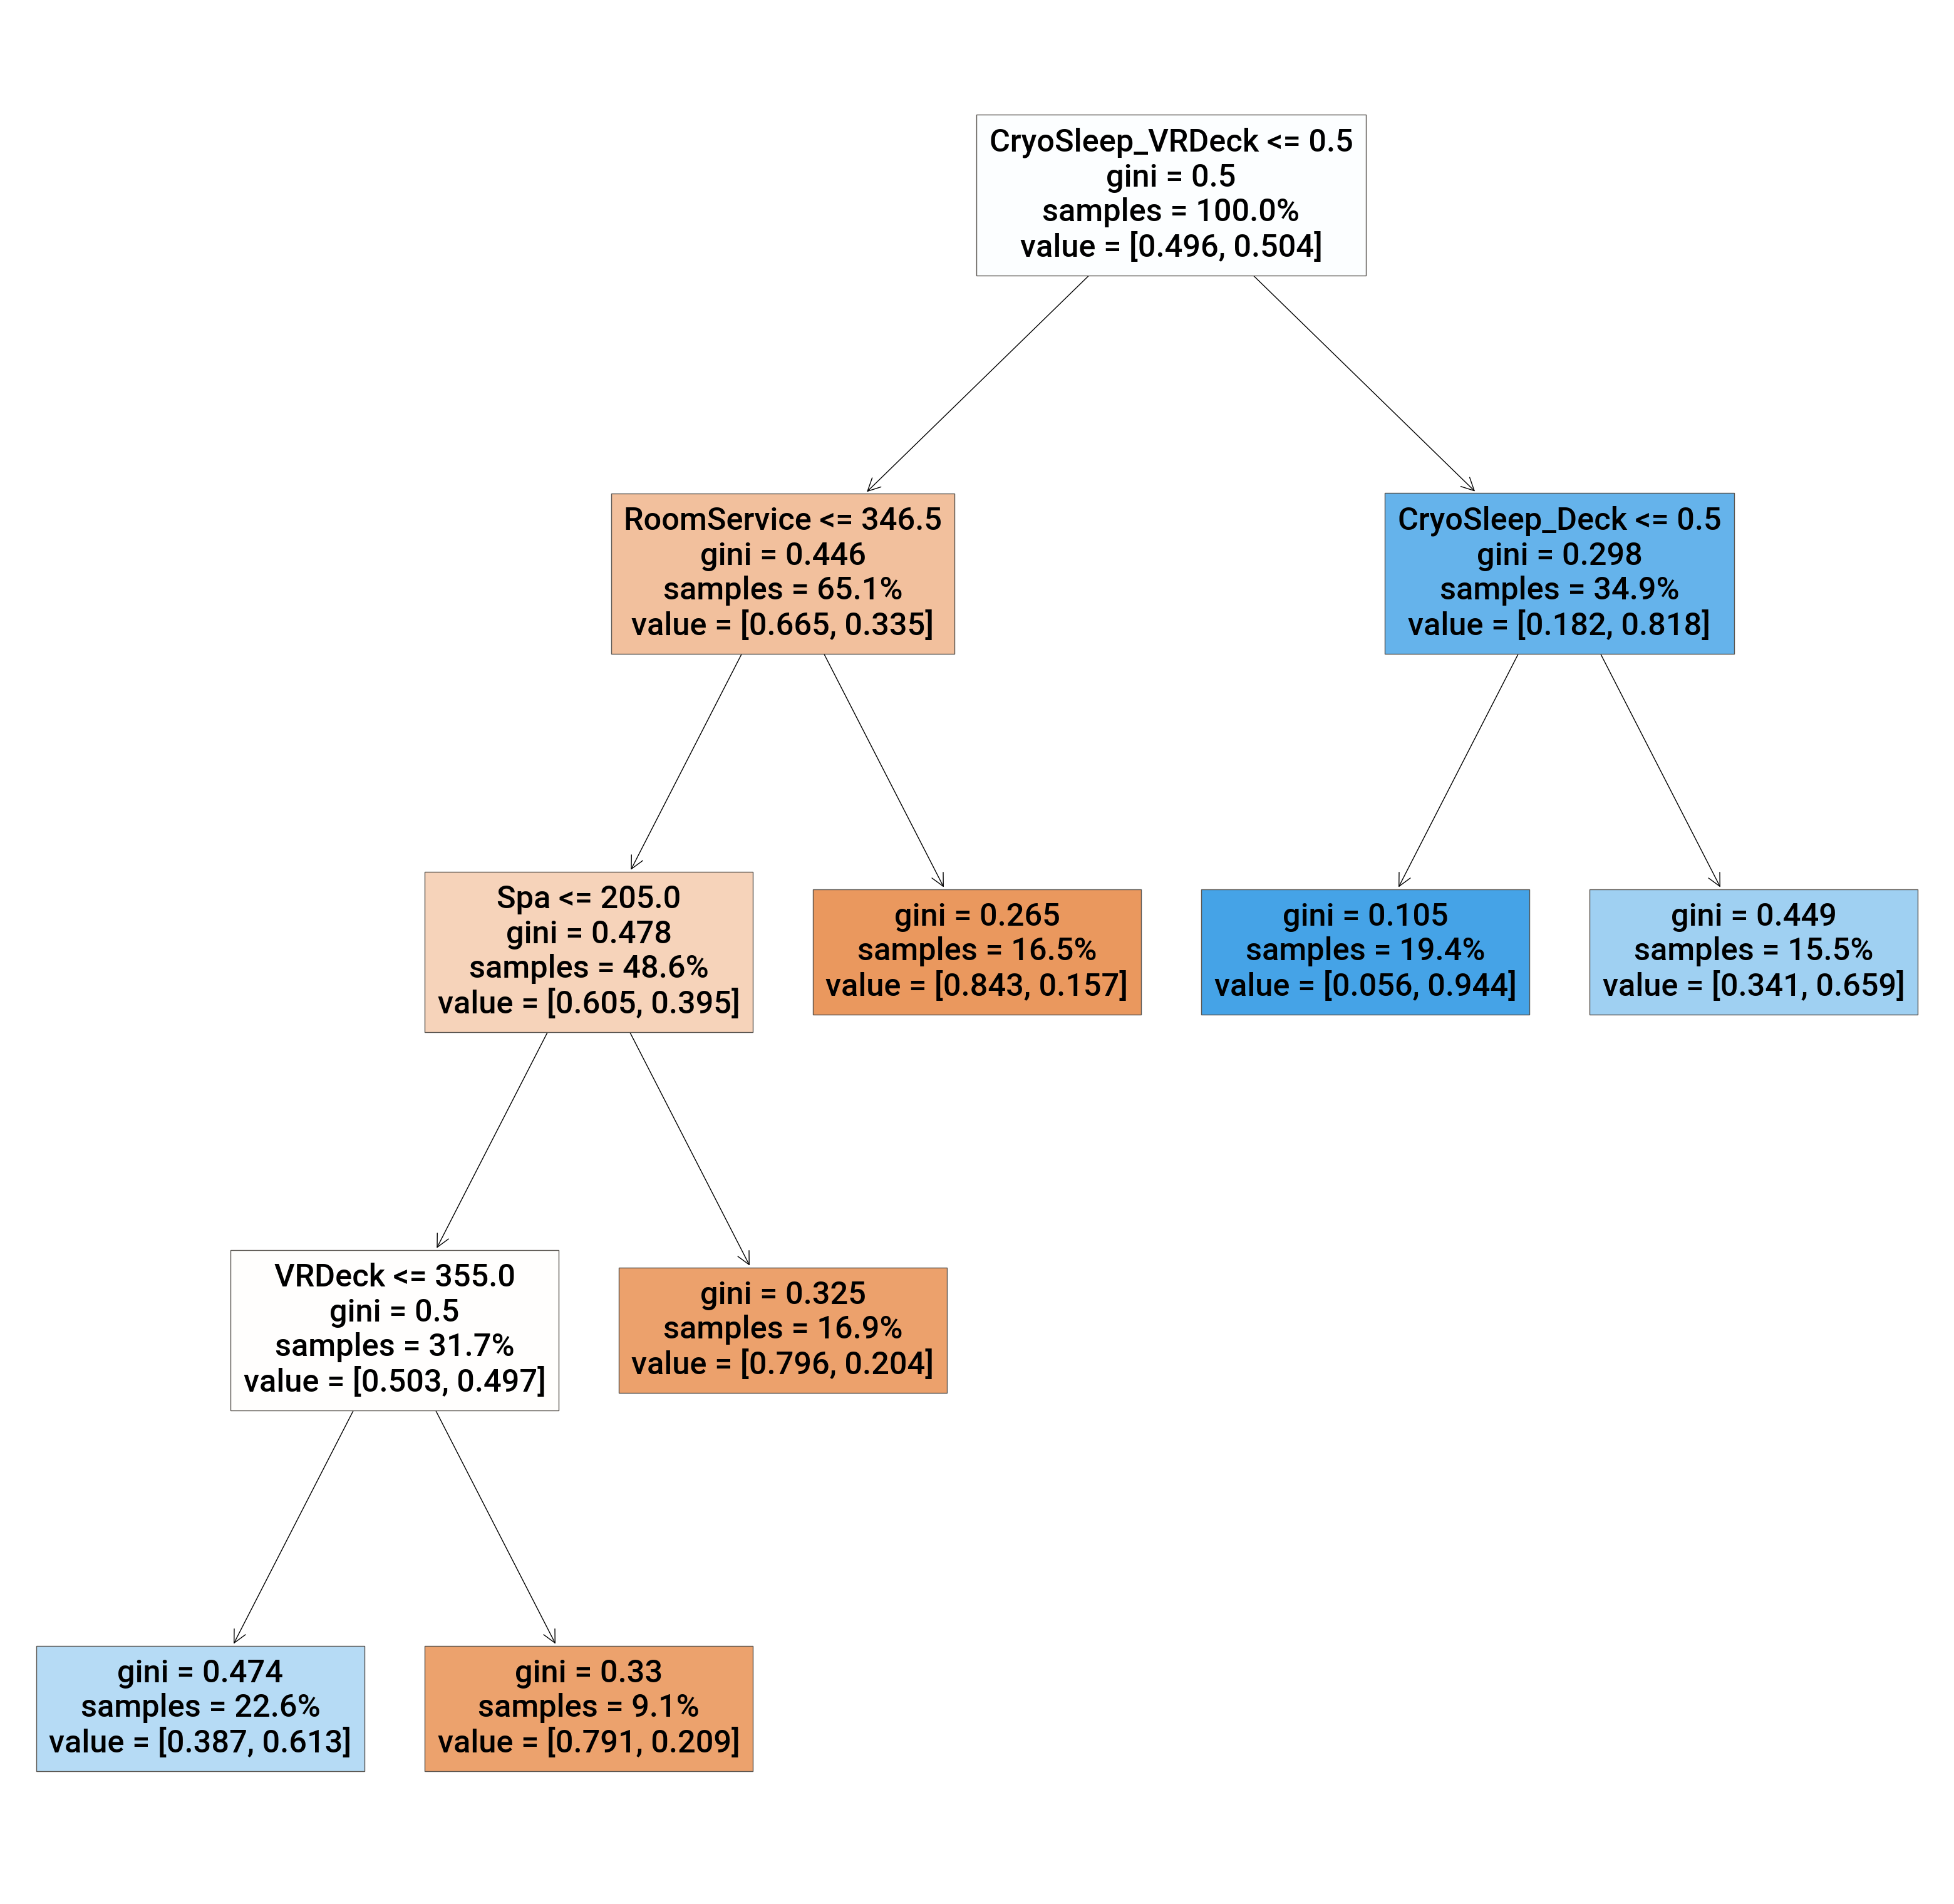

In [138]:
plt.figure(figsize=(40,40))
plot_tree(clf_dec, feature_names=train.columns, proportion=True, filled=True)
plt.show()

In [139]:
clf_ln = LogisticRegression()
clf_ln.fit(train, ytrain)

c:\users\aluga.com\appdata\local\programs\python\python39\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [140]:
clf_gnb = GaussianNB()
clf_gnb.fit(train, ytrain)

GaussianNB()

In [141]:
from sklearn.ensemble import RandomForestClassifier
clft = RandomForestClassifier(n_estimators=500) #0.79378

clft.fit(train, ytrain)

RandomForestClassifier(n_estimators=500)

In [142]:
from sklearn.ensemble import GradientBoostingClassifier 
boost = GradientBoostingClassifier(n_estimators=500).fit(train, ytrain) #0.80476

In [147]:
from sklearn.ensemble import GradientBoostingClassifier 
boost1 = GradientBoostingClassifier(n_estimators=500, max_features=20, learning_rate=0.7).fit(train, ytrain)

### Final

In [151]:
df_test = test[['PassengerId']]
df_test["Transported"] = boost.predict(test)

C:\Users\aluga.com\AppData\Local\Temp\ipykernel_17432\3757056829.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test["Transported"] = boost.predict(test)


In [152]:
df_test["Transported"] = df_test["Transported"].replace([0,1], [False, True])
#replace --> transporte para true and false
df_test.head()

C:\Users\aluga.com\AppData\Local\Temp\ipykernel_17432\817656739.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test["Transported"] = df_test["Transported"].replace([0,1], [False, True])


,PassengerId,Transported
0,0013_01,False
1,0018_01,False
2,0019_01,True
3,0021_01,True
4,0023_01,True


In [153]:
df_test.to_csv("./submission.csv", index = False)